Notebook to investigate raw FinBERT predictions (excluding results of Granger Causality & OLS, see \notebooks\exploratory_analysis_regression_results.ipnyb)

In [2]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import re
import itertools
import datetime as dt
import sqlite3
from collections import defaultdict

# connect to folder for custom functions
root = Path.cwd().parent
vis_path = root / "src" / "visualizations" 
mod_path = root / "src" / "modelling" 
sys.path.append(str(vis_path))
sys.path.append(str(mod_path))

from read_articles import read, investigate_hype_articles
from plot_functions import plot_aini_means_three_panels, plot_aini_hist_grid_by_years, plot_timeline, plot_n_articles_with_extrema_events
from compute_extrema import compute_aini_extrema
from calculate_summary_statistics import calculate_aini_statistics

In [3]:
# prepare paths
var_path = root / "data" / "processed" / "variables"
art_path = root / "data" / "processed" / "articles"
table_path = root / "reports" / "tables"
fig_path = root / "reports" / "figures"

# load aini data
aini_custom = pd.read_csv(var_path / "binary_AINI_variables.csv")
aini_w0 = pd.read_csv(var_path / "w0_AINI_variables.csv")
aini_w1 = pd.read_csv(var_path / "w1_AINI_variables.csv")
aini_w2 =  pd.read_csv(var_path / "w2_AINI_variables.csv")
aini_w2

,date,normalized_AINI,simple_AINI,EMA_02,EMA_08
0,2023-04-01,0.0,0,0.000000,0.000000
1,2023-04-02,0.0,0,0.000000,0.000000
2,2023-04-03,0.0,0,0.000000,0.000000
3,2023-04-04,0.0,0,0.000000,0.000000
4,2023-04-05,0.0,0,0.000000,0.000000
...,...,...,...,...,...
776,2025-06-12,0.0,0,0.047604,0.013605
777,2025-06-13,0.1,3,0.058083,0.082721
778,2025-06-14,0.0,0,0.046467,0.016544
779,2025-06-15,0.0,0,0.037173,0.003309


In [4]:
# create dataframes for visualizaions
normalized_AINI = pd.DataFrame()

# ensure sorting
aini_w0 = aini_w0.sort_values("date")
aini_w1 = aini_w1.sort_values("date")
aini_w2 = aini_w2.sort_values("date")
aini_custom = aini_custom.sort_values("date")

# compute extrema; exclude noisy dates & 0 AINI vals
merged, tidy, pivot, extrema = compute_aini_extrema(aini_w0,aini_w1,aini_w2,aini_custom,
                                                    exclude_dates=["2023-07-15","2023-06-30","2023-04-01","2023-04-02"])
merged

c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_nonzero[value_cols] = merged_nonzero[value_cols].apply(pd.to_numeric, errors="coerce")
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:145: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tidy.pivot_table(
c:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\src\modelling\compute_extrema.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. 

,date,normalized_AINI_w0,simple_AINI_w0,EMA_02_w0,EMA_08_w0,normalized_AINI_w1,simple_AINI_w1,EMA_02_w1,EMA_08_w1,normalized_AINI_w2,simple_AINI_w2,EMA_02_w2,EMA_08_w2,normalized_AINI_custom,simple_AINI_custom,EMA_02_custom,EMA_08_custom
2,2023-04-03,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
3,2023-04-04,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
4,2023-04-05,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,0.000000,0.000000
5,2023-04-06,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,-0.076923,-1,-0.015385,-0.061538
6,2023-04-07,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.000000,0.0,0,0.000000,0.000000,0.000000,0,-0.012308,-0.012308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
776,2025-06-12,0.000000,0,0.043486,0.014145,0.000000,0,0.035155,0.010033,0.0,0,0.047604,0.013605,-0.055556,-2,-0.098190,-0.049539
777,2025-06-13,0.033333,1,0.041456,0.029496,0.100000,3,0.048124,0.082007,0.1,3,0.058083,0.082721,-0.166667,-5,-0.111886,-0.143241
778,2025-06-14,0.000000,0,0.033164,0.005899,0.000000,0,0.038499,0.016401,0.0,0,0.046467,0.016544,0.000000,0,-0.089509,-0.028648
779,2025-06-15,0.000000,0,0.026532,0.001180,0.000000,0,0.030799,0.003280,0.0,0,0.037173,0.003309,0.000000,0,-0.071607,-0.005730


In [5]:
# show extrema
extrema.sort_values("n measures",ascending=False)

,type,date,n measures,measure
0,minimum,2025-02-06,3,"normalized_AINI_custom, EMA_02_custom, EMA_08_..."
13,maximum,2025-06-07,3,"normalized_AINI_w0, EMA_02_w0, EMA_08_w0"
14,maximum,2025-06-16,3,"normalized_AINI_w2, EMA_02_w2, EMA_08_w2"
3,minimum,2025-01-28,2,"normalized_AINI_w1, EMA_08_w1"
2,minimum,2024-08-02,2,"normalized_AINI_w2, EMA_08_w2"
1,minimum,2023-08-13,2,"normalized_AINI_w0, EMA_08_w0"
4,minimum,2025-01-31,2,"EMA_02_w1, EMA_02_w2"
15,maximum,2025-06-10,2,"normalized_AINI_w1, EMA_08_w1"
16,maximum,2023-04-09,1,EMA_02_custom
5,minimum,2025-01-20,1,EMA_02_w0


Explore differences in min, max, mean and std. of AINI variables

In [6]:
stats = calculate_aini_statistics(merged)
stats.to_html(table_path / "AINI_summary_statistics.html")
stats

,scope,variable,count,mean,std,min,median,max
0,Total,EMA_02_custom,777,-0.087874,0.031707,-0.284651,-0.086383,0.000000
1,Total,EMA_02_w0,777,-0.000685,0.019074,-0.068745,0.000072,0.058285
2,Total,EMA_02_w1,777,-0.004583,0.023217,-0.109569,-0.002466,0.057163
3,Total,EMA_02_w2,777,-0.005780,0.022230,-0.097269,-0.003288,0.069739
4,Total,EMA_08_custom,777,-0.087730,0.063610,-0.456777,-0.081409,0.000000
...,...,...,...,...,...,...,...,...
59,2025,normalized_AINI_w2,141,0.000121,0.069441,-0.208333,0.000000,0.200000
60,2025,simple_AINI_custom,141,-3.106383,3.600996,-26.000000,-2.000000,0.000000
61,2025,simple_AINI_w0,141,0.141844,1.895791,-5.000000,0.000000,7.000000
62,2025,simple_AINI_w1,141,0.078014,2.324008,-8.000000,0.000000,8.000000


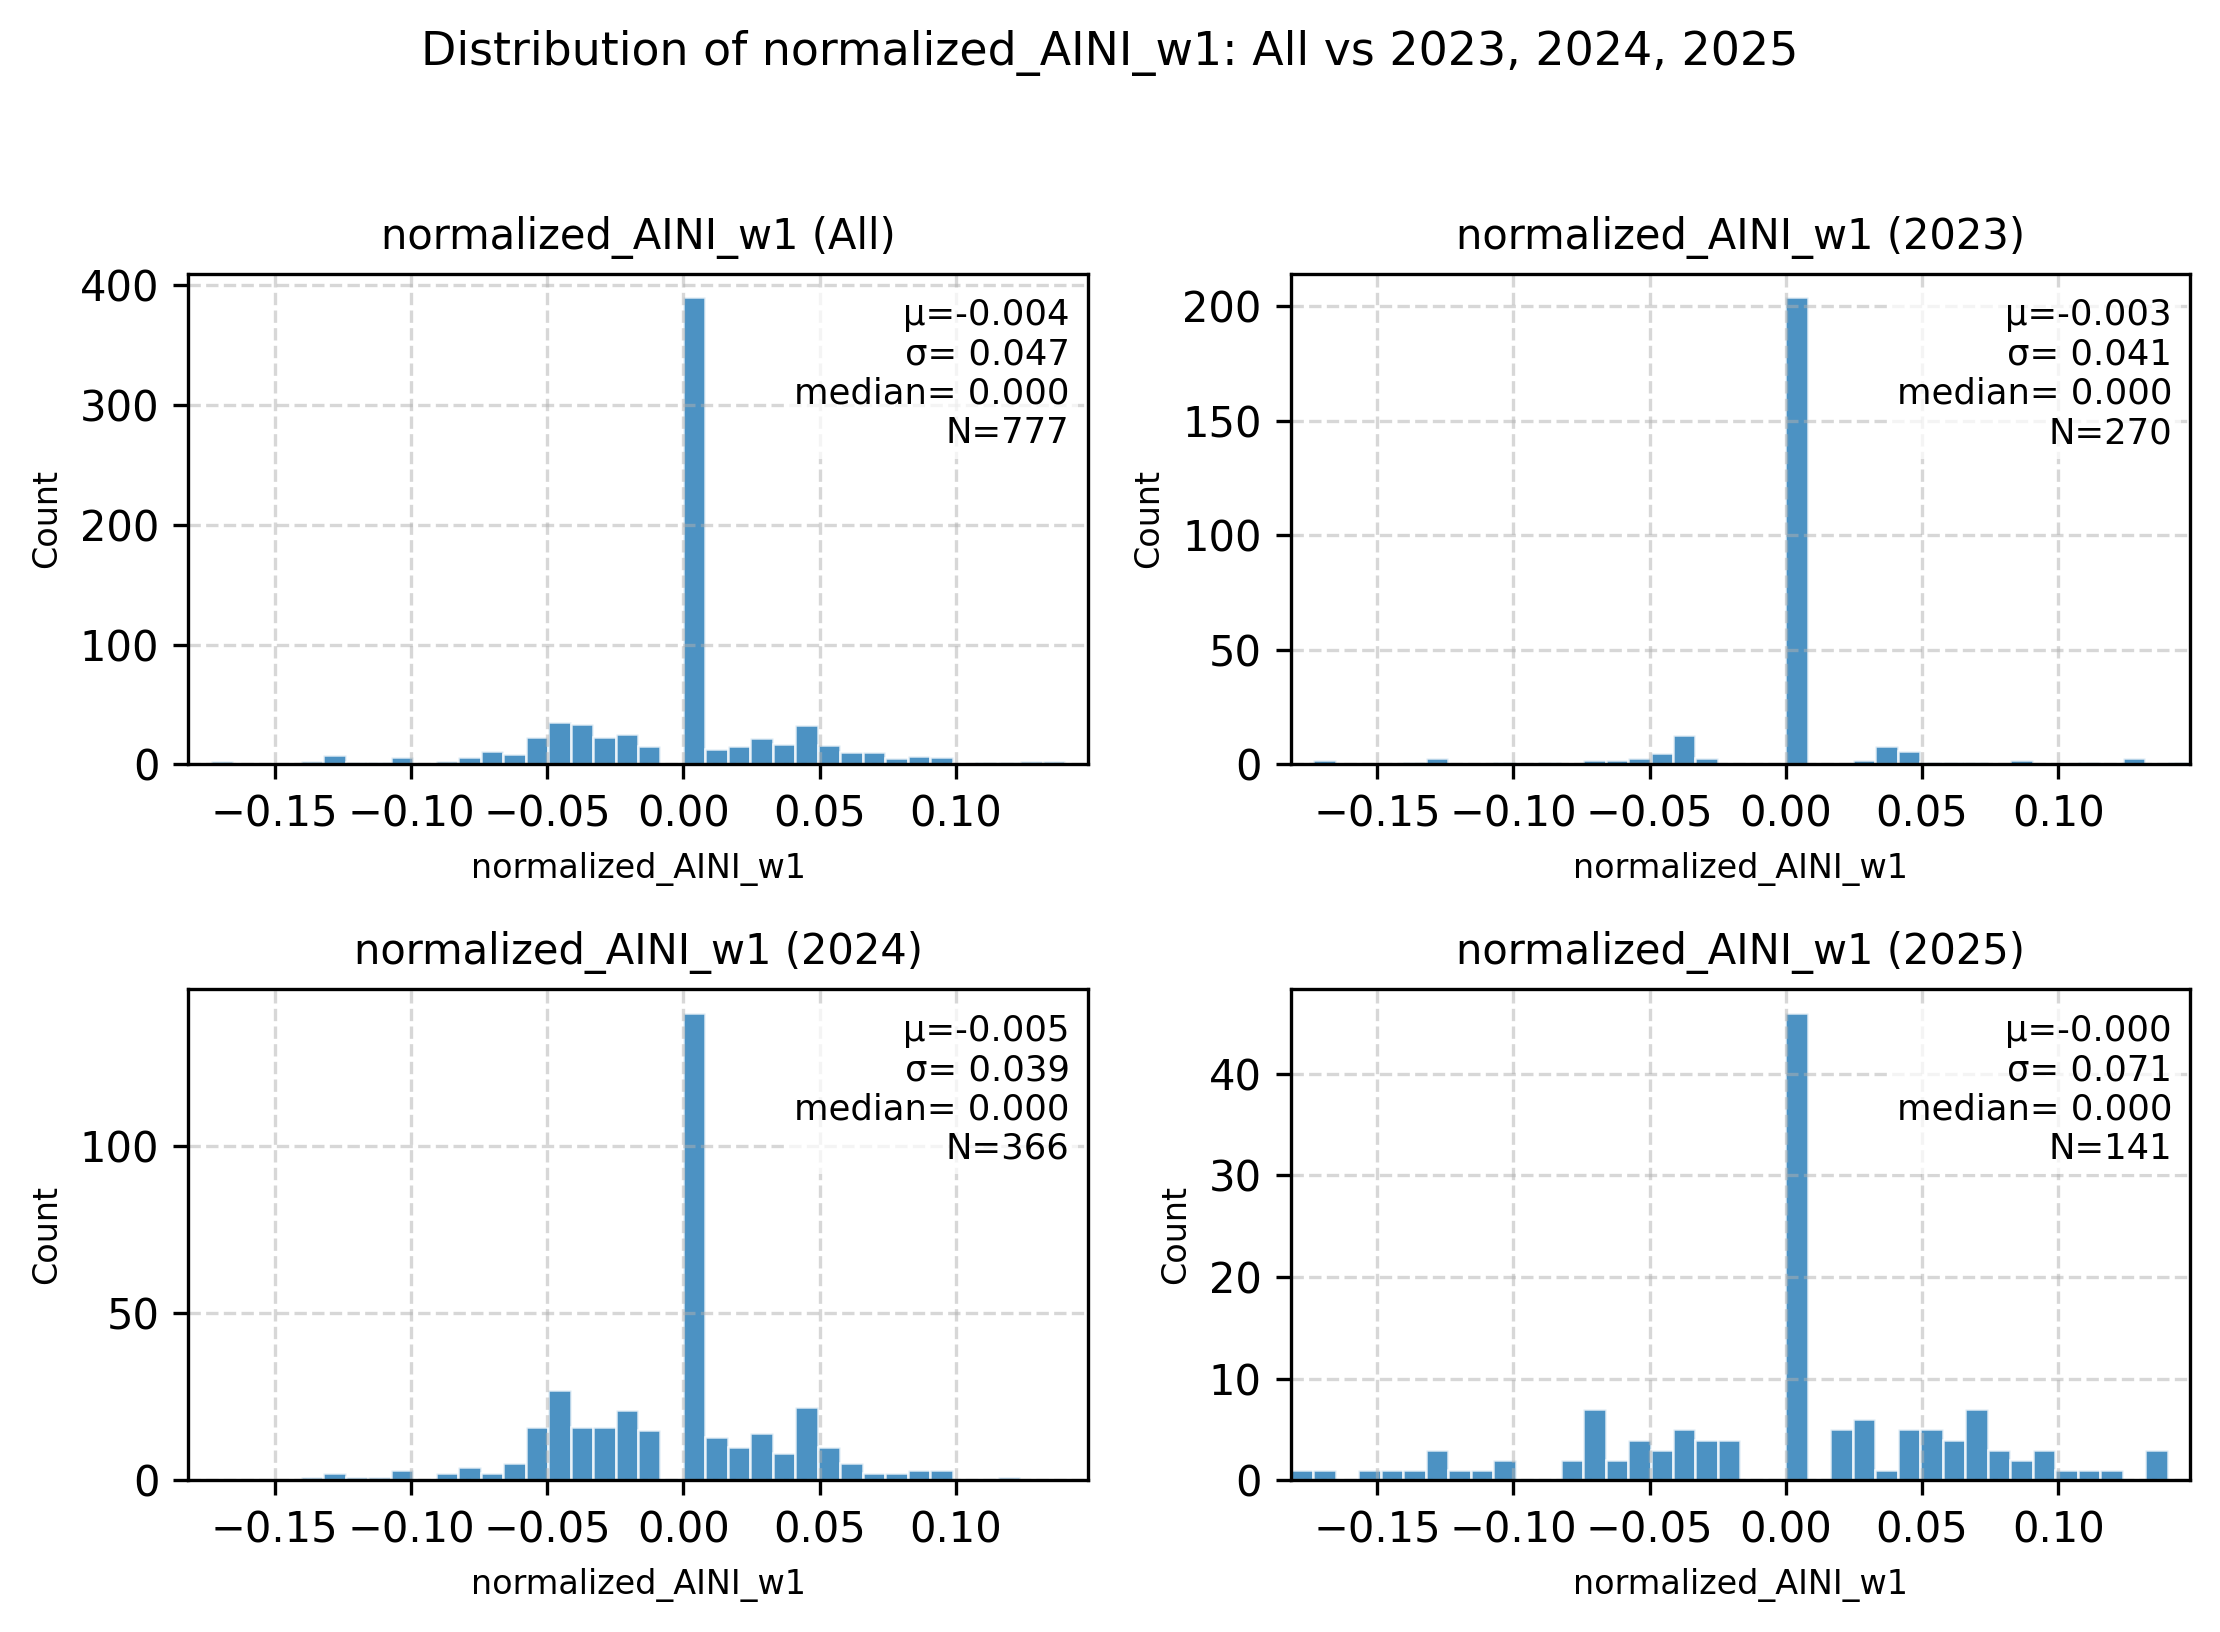

In [7]:
# plot distribution, ignoring raw counts due to unequal count of articles / day
vars = ["EMA_02_w0"] 
outpath_hist = fig_path / "aini_hist_w1_panels.png"

plot_aini_hist_grid_by_years(
            df = merged,
            outpath= outpath_hist
        )


In [8]:
# write to csv
extrema.to_csv(table_path / "aini_extrema.csv")

In [9]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

Calculate weekly extrema (by calendar week)

In [10]:
# derive calendar week (ISO year + week number)
tidy["week"] = tidy["date"].dt.to_period("W").apply(lambda r: r.start_time)

# Count how often each min/max week occurs
counts_by_week = (
    tidy.groupby(["type", "week"])
        .size()
        .reset_index(name="count")
        .sort_values(["type", "count"], ascending=[True, False])
)

# subset n > 0
extrema_weekly = counts_by_week[counts_by_week["count"] > 0]

# collect variables for each week
week_dict = (
    tidy.groupby(["week"])["variable"]
    .apply(list)
    .to_dict()
)

# attach variables to each week
extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)

# bring into convenient format
extrema_weekly_clean = extrema_weekly.copy()

# week start (Monday)
week_start = extrema_weekly_clean["week"]
# week end (Sunday) = start + 6 days
week_end = week_start + pd.Timedelta(days=6)

# format as "dd.mm.yyyy - dd.mm.yyyy"
extrema_weekly_clean["week"] = (
    week_start.dt.strftime("%d.%m.%Y") + " - " + week_end.dt.strftime("%d.%m.%Y")
)

extrema_weekly_clean["type"] = extrema_weekly_clean["type"].replace({"min": "minimum", "max": "maximum"})
extrema_weekly_clean.rename(columns={"count": "n measures"}, inplace=True)

# save
extrema_weekly_clean.to_csv(table_path / "aini_weekly_extrema.csv", index=False)

C:\Users\PC\AppData\Local\Temp\ipykernel_23284\2630997574.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tidy.groupby(["type", "week"])
C:\Users\PC\AppData\Local\Temp\ipykernel_23284\2630997574.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  extrema_weekly["measure"] = extrema_weekly["week"].map(week_dict)
C:\Users\PC\AppData\Local\Temp\ipykernel_23284\2630997574.py:38: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the

In [11]:
# Convert to LaTeX with booktabs, tabular (single-page), wrapped in adjustbox
latex_table = extrema_weekly_clean.to_latex(
    index=False,
    escape=True,
    column_format="l" + "c" * (len(extrema_weekly_clean.columns) - 1),
    bold_rows=False
)

# Add booktabs spacing
latex_table = latex_table.replace("\\toprule", "\\toprule\n\\addlinespace")
latex_table = latex_table.replace("\\midrule", "\\midrule\n\\addlinespace")
latex_table = latex_table.replace("\\bottomrule", "\\addlinespace\n\\bottomrule")

# Wrap in table + adjustbox
latex_wrapped = (
    "\\begin{table}[!htbp]\n"
    "\\centering\n"
    "\\begin{adjustbox}{width=\\textwidth}\n"
    + latex_table +
    "\\end{adjustbox}\n"
    "\\caption{AINI extrema}\n"
    "\\label{tab:aini_extrema}\n"
    "\\end{table}\n"
)

# Save to file
output_path = table_path / "aini_extrema_weekly.tex"
with open(output_path, "w") as f:
    f.write(latex_wrapped)

In [12]:
extrema_weekly_clean.sort_values("n measures",ascending=False)

,type,week,n measures,measure
6,minimum,27.01.2025 - 02.02.2025,4,"[normalized_AINI_w1, EMA_02_w1, EMA_08_w1, EMA..."
7,minimum,03.02.2025 - 09.02.2025,3,"[normalized_AINI_custom, EMA_02_custom, EMA_08..."
23,maximum,16.06.2025 - 22.06.2025,3,"[normalized_AINI_w2, EMA_02_w2, EMA_08_w2]"
21,maximum,02.06.2025 - 08.06.2025,3,"[normalized_AINI_w0, EMA_02_w0, EMA_08_w0]"
3,minimum,29.07.2024 - 04.08.2024,2,"[normalized_AINI_w2, EMA_08_w2]"
1,minimum,07.08.2023 - 13.08.2023,2,"[normalized_AINI_w0, EMA_08_w0]"
22,maximum,09.06.2025 - 15.06.2025,2,"[normalized_AINI_w1, EMA_08_w1]"
5,minimum,20.01.2025 - 26.01.2025,1,[EMA_02_w0]
12,maximum,03.04.2023 - 09.04.2023,1,[EMA_02_custom]
14,maximum,04.09.2023 - 10.09.2023,1,[EMA_08_custom]


load data with AINI predictions & compare corpora with maxima and minima

In [13]:
# load & merge w1 data custom finbert data
c_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_on_binary.csv")
c_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_on_binary.csv")
c_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_on_binary.csv")
c_df = pd.concat([c_df23,c_df24,c_df25]) 

# load & merge w0 data
w0_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_0.csv")
w0_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_0.csv")
w0_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_0.csv")
w0_df = pd.concat([w0_df23,w0_df24,w0_df25]) 

# load & merge w1 data
w1_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_1.csv")
w1_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_1.csv")
w1_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_1.csv")
w1_df = pd.concat([w1_df23,w1_df24,w1_df25]) 

# merge on normalized_aini_wo to identify relevant articles
w2_df23 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2023_windsize_2.csv")
w2_df24 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2024_windsize_2.csv")
w2_df25 = pd.read_csv(var_path / "FinBERT_AINI_prediction_2025_windsize_2.csv")
w2_df = pd.concat([w2_df23,w2_df24,w2_df25]) 

# create df list 
aini_dfs = [c_df,w0_df,w1_df,w2_df]
w0_df

,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,section,cleaned_corpus,text,ai_window,ai_relevant,sentiment_label,sentiment_score,hype_score
0,202336,NaN,2025-05-15 16:24:51,Best Buy-Owned Phone Service Faces Angry Custo...,Some Jitterbug phone users have been unable to...,Advertisement\nBUSINESS\nTELECOM\nBest Buy-Own...,154,154,2023-01-10,https://www.wsj.com/business/telecom/best-buy-...,business,Best. Buy-Owned. Phone. Service. Faces. Angry....,Best Buy-Owned Phone Service Faces Angry Custo...,NaN,False,neutral,0.000000,0
1,202339,NaN,2025-05-15 16:32:16,Biden Administration Plans to Ease Rules for I...,Proposed plan would allow low earners to pay l...,Advertisement\nPOLITICS\nPOLICY\nBiden Adminis...,157,157,2023-01-10,https://www.wsj.com/politics/policy/biden-admi...,politics,Biden. Administration. Plans to. Ease. Rules f...,Biden Administration Plans to Ease Rules for I...,NaN,False,neutral,0.000000,0
2,202387,NaN,2025-05-15 16:43:13,Garland Names Robert Hur Special Counsel to In...,Appointment comes after classified documents w...,Advertisement\nPOLITICS\nNATIONAL SECURITY\nGa...,186,186,2023-01-12,https://www.wsj.com/politics/national-security...,politics,Appointment comes after classified documents w...,Garland Names Robert Hur Special Counsel to In...,NaN,False,neutral,0.000000,0
3,2023102,NaN,2025-05-15 16:46:49,Amazon Appeal to Union Victory in New York Rej...,Company says union used inappropriate methods ...,Advertisement\nBUSINESS\nRETAIL\nAmazon Appeal...,201,201,2023-01-12,https://www.wsj.com/business/retail/amazon-app...,business,4 min. Workers from. Amazon's. Staten. Island ...,Amazon Appeal to Union Victory in New York Rej...,NaN,False,neutral,0.000000,0
4,2023111,NaN,2025-05-15 16:48:53,Before Biden Left the White House as Vice Pres...,Discovery of classified documents puts scrutin...,Before Biden Left the White House as Vice Pres...,204,204,2023-01-13,https://www.wsj.com/politics/national-security...,politics,Before. Biden. Left the. White. House as. Vice...,Before Biden Left the White House as Vice Pres...,NaN,False,neutral,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4055,20254120,NaN,2025-06-19 01:23:54,TotalEnergies Buys Stake in Chevron-Operated E...,The acquisition gives TotalEnergies access to ...,BUSINESS\nENERGY & OIL\nFollow\nTotalEnergies ...,4906,4906,2025-06-16,https://www.wsj.com/business/energy-oil/totale...,business,ENERGY. OIL. TotalEnergies. Buys. Stake in. Ch...,TotalEnergies Buys Stake in Chevron-Operated E...,NaN,False,neutral,0.000000,0
4056,20254121,NaN,2025-06-19 01:24:00,Oil Keeps Gaining as Markets Watch Middle East...,"Stock markets rebounded somewhat, but volatili...",MARKETS & FINANCE\nCOMMODITIES & FUTURES\nOil ...,4907,4907,2025-06-16,https://www.wsj.com/finance/commodities-future...,finance,MARKETS. FINANCE. COMMODITIES. FUTURES. Stock ...,Oil Keeps Gaining as Markets Watch Middle East...,NaN,False,neutral,0.000000,0
4057,20254122,NaN,2025-06-19 01:24:07,Suspect in Killing of Minnesota Lawmaker Arres...,Vance Luther Boelter is taken into custody aft...,U.S.\nSuspect in Killing of Minnesota Lawmaker...,4908,4908,2025-06-16,https://www.wsj.com/us-news/manhunt-under-way-...,us-news,U.S. Vance. Luther. Boelter is taken into cust...,Suspect in Killing of Minnesota Lawmaker Arres...,NaN,False,neutral,0.000000,0
4058,20254123,NaN,2025-06-19 01:24:14,Chinese Spenders Open Wallets as Factories Slow,Trade uncertainty and real estate weigh on ind...,ECONOMY\nChinese Spenders Open Wallets as Fact...,4909,4909,2025-06-16,https://www.wsj.com/economy/chinas-may-data-pa...,economy,38 4 min. A key measure of domestic consumptio...,Chinese Spenders Open Wallets as Factories Slo...,NaN,False,neutral,0.000000,0


In [14]:
# verify integrity 
for df in aini_dfs:
    print(
        f"\nFirst entry (date): {df['date'].min()} "
        f"\nLast entry (date): {df['date'].max()} "
        f"\n# entries: {len(df)} "
        f"\n# non-unique article_id: {df['article_id'].duplicated().sum()} "
        f"\n# unique article_id: {df['article_id'].nunique()} " 
        f"\nMin article_id: {df['article_id'].min()} "
        f"\nMax article_id: {df['article_id'].max()} "
        f"\nColumns: {list(df.columns)}\n"
    )



First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 21886 
# non-unique article_id: 0 
# unique article_id: 21886 
Min article_id: 20251 
Max article_id: 202437460 
Columns: ['article_id', 'image_src', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus', 'ai_window', 'predicted_label', 'predicted_class', 'ai_relevant', 'sentiment_label', 'sentiment_score', 'hype_score']


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
# unique article_id: 22904 
Min article_id: 20251 
Max article_id: 202437460 
Columns: ['article_id', 'image_src', 'scanned_time', 'title', 'sub_title', 'corpus', 'index_id', 'id', 'date', 'link', 'section', 'cleaned_corpus', 'text', 'ai_window', 'ai_relevant', 'sentiment_label', 'sentiment_score', 'hype_score']


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
# unique a

In [15]:
# investigate duplicates in article ids
dups = w0_df[w0_df[["article_id", "title"]].duplicated(keep=False)].sort_values("article_id")
dups

,article_id,image_src,scanned_time,title,sub_title,corpus,index_id,id,date,link,section,cleaned_corpus,text,ai_window,ai_relevant,sentiment_label,sentiment_score,hype_score


In [16]:
# subset for relevant columns
rel_col = ["date","article_id","sentiment_label","hype_score","ai_window"]
clean_df = []

for df in aini_dfs:
    df = df[rel_col].copy()
    clean_df.append(df)
    
# unpack supsetted dataframes containing Finbert AINI estimates    
c_df_sub,w0_df_sub,w1_df_sub,w2_df_sub = clean_df
w2_df_sub

,date,article_id,sentiment_label,hype_score,ai_window
0,2023-01-10,202336,neutral,0,NaN
1,2023-01-10,202339,neutral,0,NaN
2,2023-01-12,202387,neutral,0,NaN
3,2023-01-12,2023102,neutral,0,NaN
4,2023-01-13,2023111,neutral,0,NaN
...,...,...,...,...,...
4055,2025-06-16,20254120,neutral,0,NaN
4056,2025-06-16,20254121,neutral,0,NaN
4057,2025-06-16,20254122,neutral,0,NaN
4058,2025-06-16,20254123,neutral,0,NaN


In [17]:
# verify integrity 
for df in clean_df:
    print(
        f"First entry (date): {df['date'].min()} "
        f"\nLast entry (date): {df['date'].max()} "
        f"\n# entries: {len(df)} "
        f"\n# non-unique article_id: {df['article_id'].duplicated().sum()} "
        f"\nColumns: {list(df.columns)}\n"
    )


First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 21886 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']

First entry (date): 2023-01-03 
Last entry (date): 2025-06-16 
# entries: 22904 
# non-unique article_id: 0 
Columns: ['date', 'article_id', 'sentiment_label', 'hype_score', 'ai_window']



Combine AINI predictions to investigate minima & maxima

In [18]:
# harmonize ids
w0 = w0_df_sub.copy()
w1 = w1_df_sub.copy()
w2 = w2_df_sub.copy()
c  = c_df_sub.copy()

# bring to datetime, normalize to 00:00:00
for df in (w0, w1, w2, c):
    df["date"] = pd.to_datetime(df["date"], errors="coerce").dt.normalize()

# left join
complete_left = w0.copy()
complete_left = complete_left.merge(
    w1, on="article_id", how="left", suffixes=("", "_w1"), validate="one_to_one"
)
complete_left = complete_left.merge(
    w2, on="article_id", how="left", suffixes=("", "_w2"), validate="one_to_one"
)
complete_left = complete_left.merge(
    c,  on="article_id", how="left", suffixes=("", "_c"),  validate="one_to_one"
)

# control: outer join
complete_outer = w0.merge(
    w1, on="article_id", how="outer", suffixes=("", "_w1"), validate="one_to_one"
)
complete_outer = complete_outer.merge(
    w2, on="article_id", how="outer", suffixes=("", "_w2"), validate="one_to_one"
)
complete_outer = complete_outer.merge(
    c,  on="article_id", how="outer", suffixes=("", "_c"),  validate="one_to_one"
)


# compare joins
print("[LEFT] n observations:", len(complete_left))
print("[OUTER] n observations:", len(complete_outer))
complete_left

[LEFT] n observations: 22904
[OUTER] n observations: 22904


,date,article_id,sentiment_label,hype_score,ai_window,date_w1,sentiment_label_w1,hype_score_w1,ai_window_w1,date_w2,sentiment_label_w2,hype_score_w2,ai_window_w2,date_c,sentiment_label_c,hype_score_c,ai_window_c
0,2023-01-10,202336,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
1,2023-01-10,202339,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
2,2023-01-12,202387,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
3,2023-01-12,2023102,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
4,2023-01-13,2023111,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22899,2025-06-16,20254120,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22900,2025-06-16,20254121,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22901,2025-06-16,20254122,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22902,2025-06-16,20254123,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN


In [19]:
# columns to bring over from w1_df
keep = ["article_id", "title", "sub_title","section", "cleaned_corpus", "date","ai_window"]

# subset + clean IDs on the right side
for_texts = w1_df.loc[:, keep].copy()
for_texts["article_id"] = (
    for_texts["article_id"]
    .astype(str)
    .str.replace(r"[\u200b\u200c\u200d\ufeff]", "", regex=True)  # zero-width + BOM
    .str.strip()
)

# ensure right side has unique keys 
for_texts = for_texts.drop_duplicates(subset="article_id", keep="first")

# clean IDs on the left
complete_left = complete_left.copy()
complete_left["article_id"] = (
    complete_left["article_id"]
    .astype(str)
    .str.replace(r"[\u200b\u200c\u200d\ufeff]", "", regex=True)
    .str.strip()
)

# go for left join (validated by inner)
complete_df = complete_left.copy()

# rename for consistency
complete_df = complete_df.rename(columns={"hype_score": "hype_score_w0"})
complete_df

,date,article_id,sentiment_label,hype_score_w0,ai_window,date_w1,sentiment_label_w1,hype_score_w1,ai_window_w1,date_w2,sentiment_label_w2,hype_score_w2,ai_window_w2,date_c,sentiment_label_c,hype_score_c,ai_window_c
0,2023-01-10,202336,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
1,2023-01-10,202339,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0,NaN,2023-01-10,neutral,0.0,NaN
2,2023-01-12,202387,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
3,2023-01-12,2023102,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0,NaN,2023-01-12,neutral,0.0,NaN
4,2023-01-13,2023111,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0,NaN,2023-01-13,neutral,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22899,2025-06-16,20254120,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22900,2025-06-16,20254121,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22901,2025-06-16,20254122,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN
22902,2025-06-16,20254123,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0,NaN,2025-06-16,neutral,0.0,NaN


C:\Users\PC\AppData\Local\Temp\ipykernel_23284\2337388238.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["hype_score_mean"] = complete_df[hype_cols].mean(axis=1)
C:\Users\PC\AppData\Local\Temp\ipykernel_23284\2337388238.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")


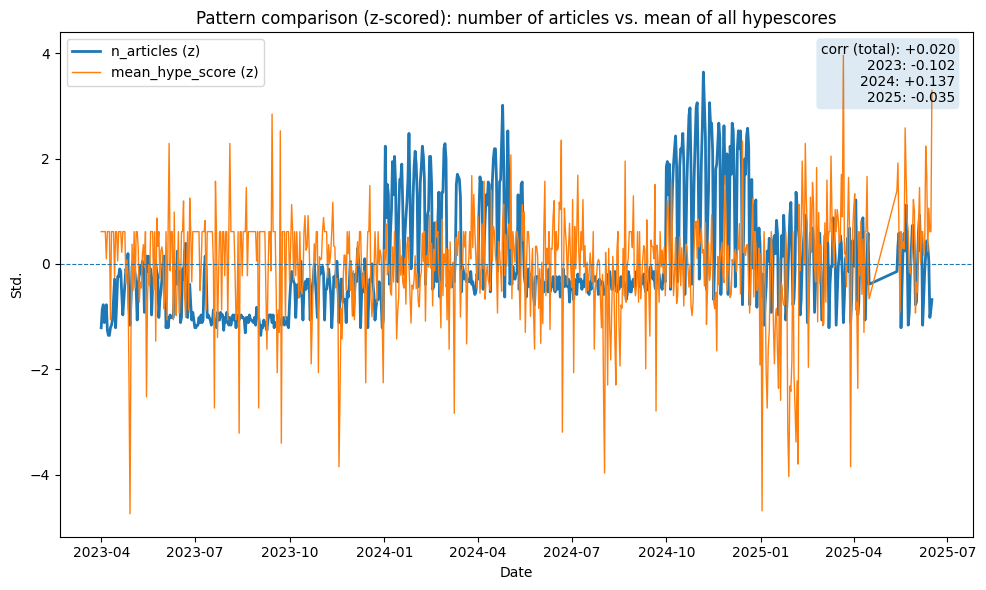

In [20]:
# define noisy dates 
exclude_dates=["2023-07-15","2023-06-30"]

# subset to exclude noise
complete_df = complete_df[~complete_df["date"].isin(pd.to_datetime(exclude_dates))]

# define relevant columns
hype_cols = ["hype_score_w0", "hype_score_w1", "hype_score_w2", "hype_score_c"]

# compute row-wise mean across all hype scores (per article)
complete_df["hype_score_mean"] = complete_df[hype_cols].mean(axis=1)

# aggregate to date level: count articles and mean of the row-wise mean
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")
complete_agg = (
    complete_df.groupby("date", as_index=False)
    .agg(
        n_articles=("article_id", "count"),
        mean_hype_score=("hype_score_mean", "mean")
    )
)

# subset to exclude data prior 01.04.2023
cutoff = dt.datetime(2023, 4, 1)
complete_agg = complete_agg[complete_agg["date"] >= cutoff]

# prepare dataframe for plotting
dfp = complete_agg.set_index("date").copy()

# z-score helper that avoids div-by-zero
def zscore(s: pd.Series) -> pd.Series:
    mu = s.mean()
    sd = s.std()
    if pd.isna(sd) or sd == 0:
        return s * 0  # all zeros if no variation
    return (s - mu) / sd

# z-score series
dfp["n_articles_z"] = zscore(dfp["n_articles"])
dfp["mean_hype_score_z"] = zscore(dfp["mean_hype_score"])

# total corr
r_total = float(dfp["n_articles_z"].corr(dfp["mean_hype_score_z"]))

# yearly corrs
yearly_corrs = {}
for y, g in dfp.groupby(dfp.index.year):
    if len(g) >= 2:
        yearly_corrs[int(y)] = float(g["n_articles_z"].corr(g["mean_hype_score_z"]))
    else:
        yearly_corrs[int(y)] = np.nan

# build annotation text
lines = [f"corr (total): {r_total:+.3f}"]
for y in sorted(yearly_corrs):
    r = yearly_corrs[y]
    lines.append(f"{y}: {r:+.3f}" if np.isfinite(r) else f"{y}: n/a")
anno_text = "\n".join(lines)

# plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dfp.index, dfp["n_articles_z"], linewidth=2, label="n_articles (z)")
ax.plot(dfp.index, dfp["mean_hype_score_z"], linewidth=1, label="mean_hype_score (z)")

ax.axhline(0, linestyle="--", linewidth=0.8)
ax.set_title("Pattern comparison (z-scored): number of articles vs. mean of all hypescores")
ax.set_xlabel("Date")
ax.set_ylabel("Std.")
ax.legend(loc="upper left", ncol=1)

# annotation box (upper right inside axes)
ax.text(
    0.98, 0.98, anno_text,
    transform=ax.transAxes,
    ha="right", va="top",
    fontsize=10,
    bbox=dict(boxstyle="round", alpha=0.15, edgecolor="none")
)

fig.tight_layout()
plt.show()

Investigate yearly correlation between raw hype scores & number of articles

In [21]:
# define hype cols present
hcols_present = [c for c in hype_cols if c in complete_df.columns]

# aggregate to date level: counts + daily means for each hype variant
complete_agg = (
    complete_df.groupby("date", as_index=False)
    .agg(
        n_articles=("article_id", "count"),
        **{f"{c}_mean": (c, "mean") for c in hcols_present},
        mean_hype_score=("hype_score_mean", "mean")  
    )
)

# build dfp
dfp = complete_agg.set_index("date").copy()

# z-score
dfp["n_articles_z"] = zscore(dfp["n_articles"])
for c in hcols_present:
    dfp[f"{c}_mean_z"] = zscore(dfp[f"{c}_mean"])

# total correlations
total_corrs = {c: float(dfp["n_articles_z"].corr(dfp[f"{c}_mean_z"])) for c in hcols_present}

# yearly correlations
corr_by_year = (
    dfp.assign(year=dfp.index.year)
       .groupby("year")
       .apply(lambda g: pd.Series({
           c: float(g["n_articles_z"].corr(g[f"{c}_mean_z"])) if len(g) >= 2 else np.nan
           for c in hcols_present
       }))
       .sort_index()
)

# append total row
corr_by_year.loc["total"] = pd.Series(total_corrs)

print(corr_by_year.round(3)) 

# subset for reporting
n_articles_df = complete_agg.loc[:, ["date", "n_articles"]].copy()

# save as scv
n_articles_df.to_csv(var_path / "n_articles.csv")

       hype_score_w0  hype_score_w1  hype_score_w2  hype_score_c
year                                                            
2023          -0.000         -0.004         -0.037         0.034
2024           0.032          0.087          0.120         0.112
2025           0.059          0.090          0.111        -0.330
total          0.045          0.044          0.067        -0.021


C:\Users\PC\AppData\Local\Temp\ipykernel_23284\3522836586.py:29: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


Compute correlation between n articles & processed AINI values

In [22]:
MEASURE_COLS = [
    "normalized_AINI_w0", "EMA_02_w0", "EMA_08_w0",
    "normalized_AINI_w1",  "EMA_02_w1", "EMA_08_w1",
    "normalized_AINI_w2", "EMA_02_w2", "EMA_08_w2",
    "normalized_AINI_custom", "EMA_02_custom", "EMA_08_custom",
]

merged_df = merged.copy()
merged_df["date"] = pd.to_datetime(merged_df["date"], errors="coerce")
merged_df = merged_df.dropna(subset=["date"])
present_measures = [c for c in MEASURE_COLS if c in merged_df.columns]

n_base = complete_agg[["date", "n_articles"]].copy()

# join measures with n_articles on date 
m = (
    merged_df[["date"] + present_measures]
    .merge(n_base, on="date", how="inner")
    .sort_values("date")
)

# verify integrity
print(f"Number of measures {m.shape[0]}",
      f"\n First datapoint: {min(m.date)}",
      f"\n Last datapoint: {max(m.date)}",
      f"\n Duplicates: {m['date'].duplicated().sum()}")

Number of measures 777 
 First datapoint: 2023-04-03 00:00:00 
 Last datapoint: 2025-06-16 00:00:00 
 Duplicates: 0


In [23]:
# helper for correlations
def _corr_block(g: pd.DataFrame, measures) -> pd.Series:
    out = {}
    for c in measures:
        if g[c].notna().sum() >= 2 and g["n_articles"].notna().sum() >= 2:
            out[c] = float(g["n_articles"].corr(g[c]))
        else:
            out[c] = np.nan
    return pd.Series(out)

# add year column
m["year"] = m["date"].dt.year

# compute by year
corr_by_year = m.groupby("year", dropna=True).apply(lambda g: _corr_block(g, present_measures))

# add total row
corr_by_year.loc["total"] = _corr_block(m, present_measures)

# pretty output
corr_by_year_rounded = corr_by_year.round(3)
print(corr_by_year_rounded)

       normalized_AINI_w0  EMA_02_w0  EMA_08_w0  normalized_AINI_w1  \
year                                                                  
2023               -0.039     -0.090     -0.045              -0.053   
2024                0.032      0.039      0.035               0.087   
2025                0.059     -0.022      0.063               0.090   
total               0.029      0.048      0.036               0.032   

       EMA_02_w1  EMA_08_w1  normalized_AINI_w2  EMA_02_w2  EMA_08_w2  \
year                                                                    
2023      -0.058     -0.046              -0.124     -0.114     -0.126   
2024       0.162      0.100               0.120      0.212      0.137   
2025      -0.044      0.076               0.111     -0.019      0.108   
total      0.035      0.036               0.058      0.082      0.066   

       normalized_AINI_custom  EMA_02_custom  EMA_08_custom  
year                                                         
2023      

C:\Users\PC\AppData\Local\Temp\ipykernel_23284\3378966710.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  corr_by_year = m.groupby("year", dropna=True).apply(lambda g: _corr_block(g, present_measures))


Investigate extrema manually

In [24]:
# exclude 0 values [created due to symmetrie]
extrema = extrema[extrema["n measures"] > 0]

# again display extrema to define minima & maxima
extrema.sort_values(["type","n measures"],ascending=(False,False))

,type,date,n measures,measure
13,maximum,2025-06-07,3,"normalized_AINI_w0, EMA_02_w0, EMA_08_w0"
14,maximum,2025-06-16,3,"normalized_AINI_w2, EMA_02_w2, EMA_08_w2"
15,maximum,2025-06-10,2,"normalized_AINI_w1, EMA_08_w1"
16,maximum,2023-04-09,1,EMA_02_custom
17,maximum,2023-09-07,1,EMA_08_custom
18,maximum,2024-10-10,1,normalized_AINI_custom
19,maximum,2025-03-22,1,EMA_02_w1
0,minimum,2025-02-06,3,"normalized_AINI_custom, EMA_02_custom, EMA_08_..."
1,minimum,2023-08-13,2,"normalized_AINI_w0, EMA_08_w0"
2,minimum,2024-08-02,2,"normalized_AINI_w2, EMA_08_w2"


In [25]:

# cutoffs for minima 
min_1_custom  = pd.Timestamp("2025-02-06")  # n = 3 normalized_AINI_custom, EMA_02_custom, EMA_08_custom
min_2_w0      = pd.Timestamp("2023-08-13")  # n = 2 normalized_AINI_w0, EMA_08_w0
min_2_w1      = pd.Timestamp("2025-01-28")  # n = 2 normalized_AINI_w1, EMA_08_w1
min_2_w2      = pd.Timestamp("2024-08-02")  # n = 2 normalized_AINI_w2, EMA_08_w2
min_2_w1_w2   = pd.Timestamp("2025-01-31")  # n = 2 EMA_02_w1, EMA_02_w2 => only mixed!
min_3_w0_02   = pd.Timestamp("2025-01-20")  # n = 1 EMA_02_w0

# cutoffs for maxima, n = 3  
max_1_w0 = pd.Timestamp("2025-06-07")  # n = 3 normalized_AINI_w0, EMA_02_w0, EMA_08_w0
max_1_w2 = pd.Timestamp("2025-06-16")  # n = 3 normalized_AINI_w2, EMA_02_w2, EMA_08_w2

# cutoffs for maxima, n = 2  
max_2_w1 = pd.Timestamp("2025-06-10")  # n = 2 normalized_AINI_w1, EMA_08_w1            

# cutoffs for maxima, n = 1 
max_3_c_norm = pd.Timestamp("2024-10-10")  # n = 1 normalized_AINI_custom
max_3_c_02   = pd.Timestamp("2023-04-09")  # n = 1 EMA_02_custom
max_3_c_08   = pd.Timestamp("2023-09-07")  # n = 1 EMA_08_custom
max_3_w1_02  = pd.Timestamp("2025-03-22")  # n = 1 EMA_02_w1

# define cutoffs in a dict: name -> timestamp (single definition)
cutoffs = {
    # maxima, n=3
    "art_max_1_w0": max_1_w0,
    "art_max_1_w2": max_1_w2,
    # maxima, n=2
    "art_max_2_w1": max_2_w1,
    # maxima, n=1
    "art_max_3_c_norm": max_3_c_norm,
    "art_max_3_c_02":   max_3_c_02,
    "art_max_3_c_08":   max_3_c_08,
    "art_max_3_w1_02":  max_3_w1_02,
    # minima, n=3
    "art_min_1_custom": min_1_custom,
    # minima, n=2
    "art_min_2_w0":    min_2_w0,
    "art_min_2_w1":    min_2_w1,
    "art_min_2_w2":    min_2_w2,
    "art_min_2_w1_w2": min_2_w1_w2,
    # minima, n=1
    "art_min_3_w0_02": min_3_w0_02,
}

# ensure datetime
complete_df = complete_df.copy()
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")

# subset original dataframe by each cutoff date
subsets = {
    name: complete_df.loc[complete_df["date"] == ts].copy()
    for name, ts in cutoffs.items()
}

# helper to count NA-rows for sanity check
def count_nonzero_rows(df, cols=None):
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.tolist()
    arr = df[cols].fillna(0).to_numpy() if cols else np.empty((len(df), 0))
    return int((arr != 0).any(axis=1).sum()) if arr.size else 0

# check n of observations for all cutoffs (per subset)
for name, df in subsets.items():
    hype_cols = [c for c in ["hype_score_w0","hype_score_w1","hype_score_w2","hype_score_custom","hype_score_c"] if c in df.columns]
    n_nonzero = count_nonzero_rows(df, cols=hype_cols or None)
    print(f"{name}: Total: {len(df)} non-0: {n_nonzero}")

art_max_1_w0: Total: 5 non-0: 1
art_max_1_w2: Total: 15 non-0: 3
art_max_2_w1: Total: 33 non-0: 9
art_max_3_c_norm: Total: 79 non-0: 6
art_max_3_c_02: Total: 1 non-0: 0
art_max_3_c_08: Total: 5 non-0: 0
art_max_3_w1_02: Total: 6 non-0: 1
art_min_1_custom: Total: 44 non-0: 24
art_min_2_w0: Total: 7 non-0: 2
art_min_2_w1: Total: 36 non-0: 11
art_min_2_w2: Total: 19 non-0: 5
art_min_2_w1_w2: Total: 33 non-0: 5
art_min_3_w0_02: Total: 23 non-0: 5


Saved: C:\Users\PC\Desktop\Masterarbeit\AI_narrative_index\reports\figures\extrema_timeline.png


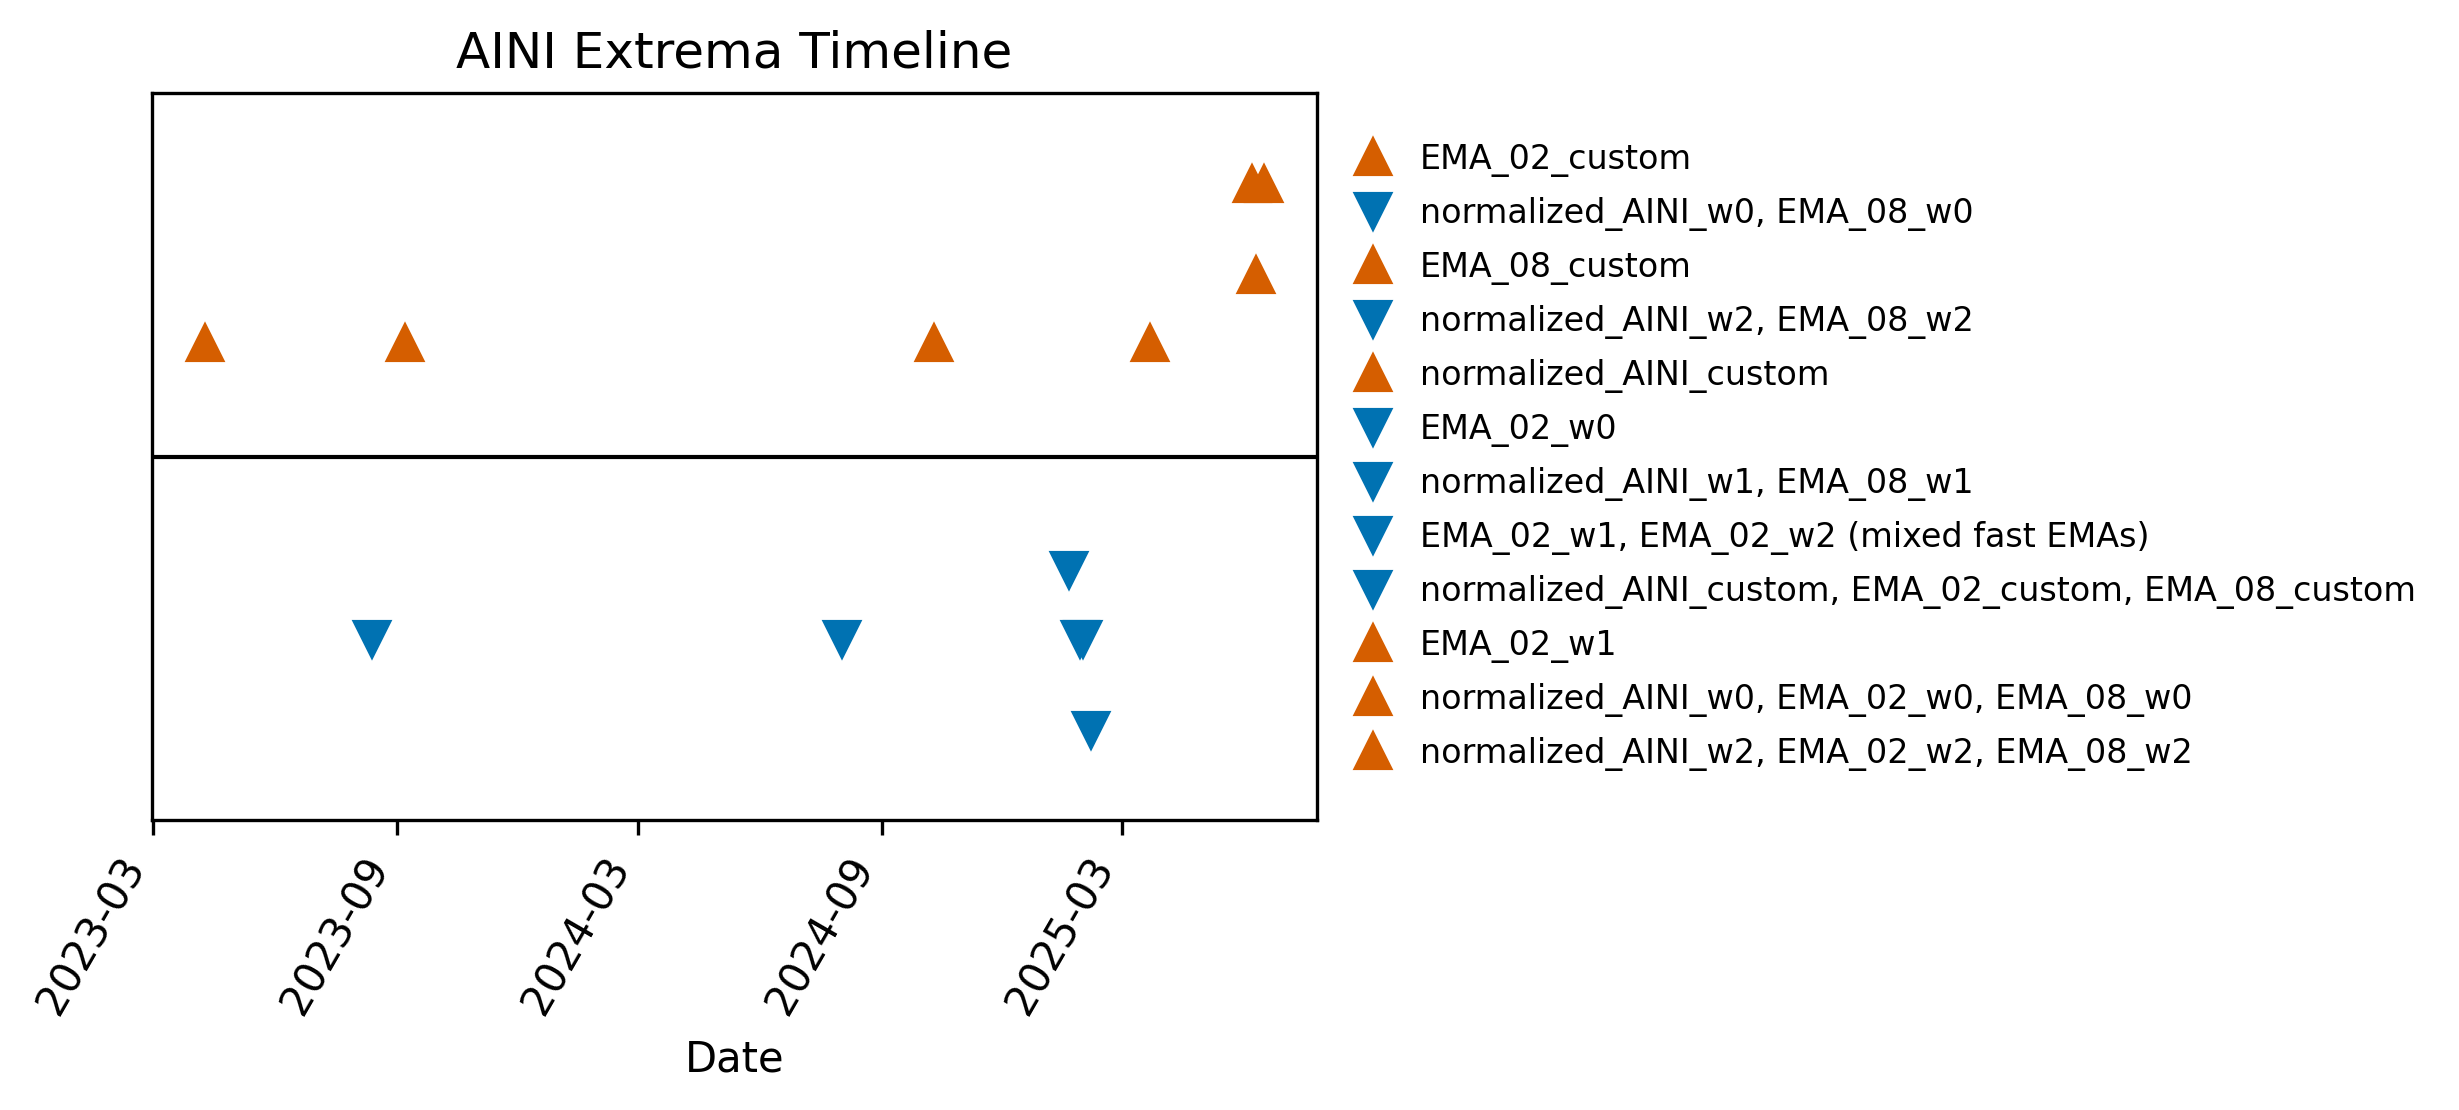

In [26]:
# investigate distribution via timeline
outpath = fig_path / "extrema_timeline.png"
fig, ax = plot_timeline(outpath=str(outpath))
print(f"Saved: {outpath.resolve()}")

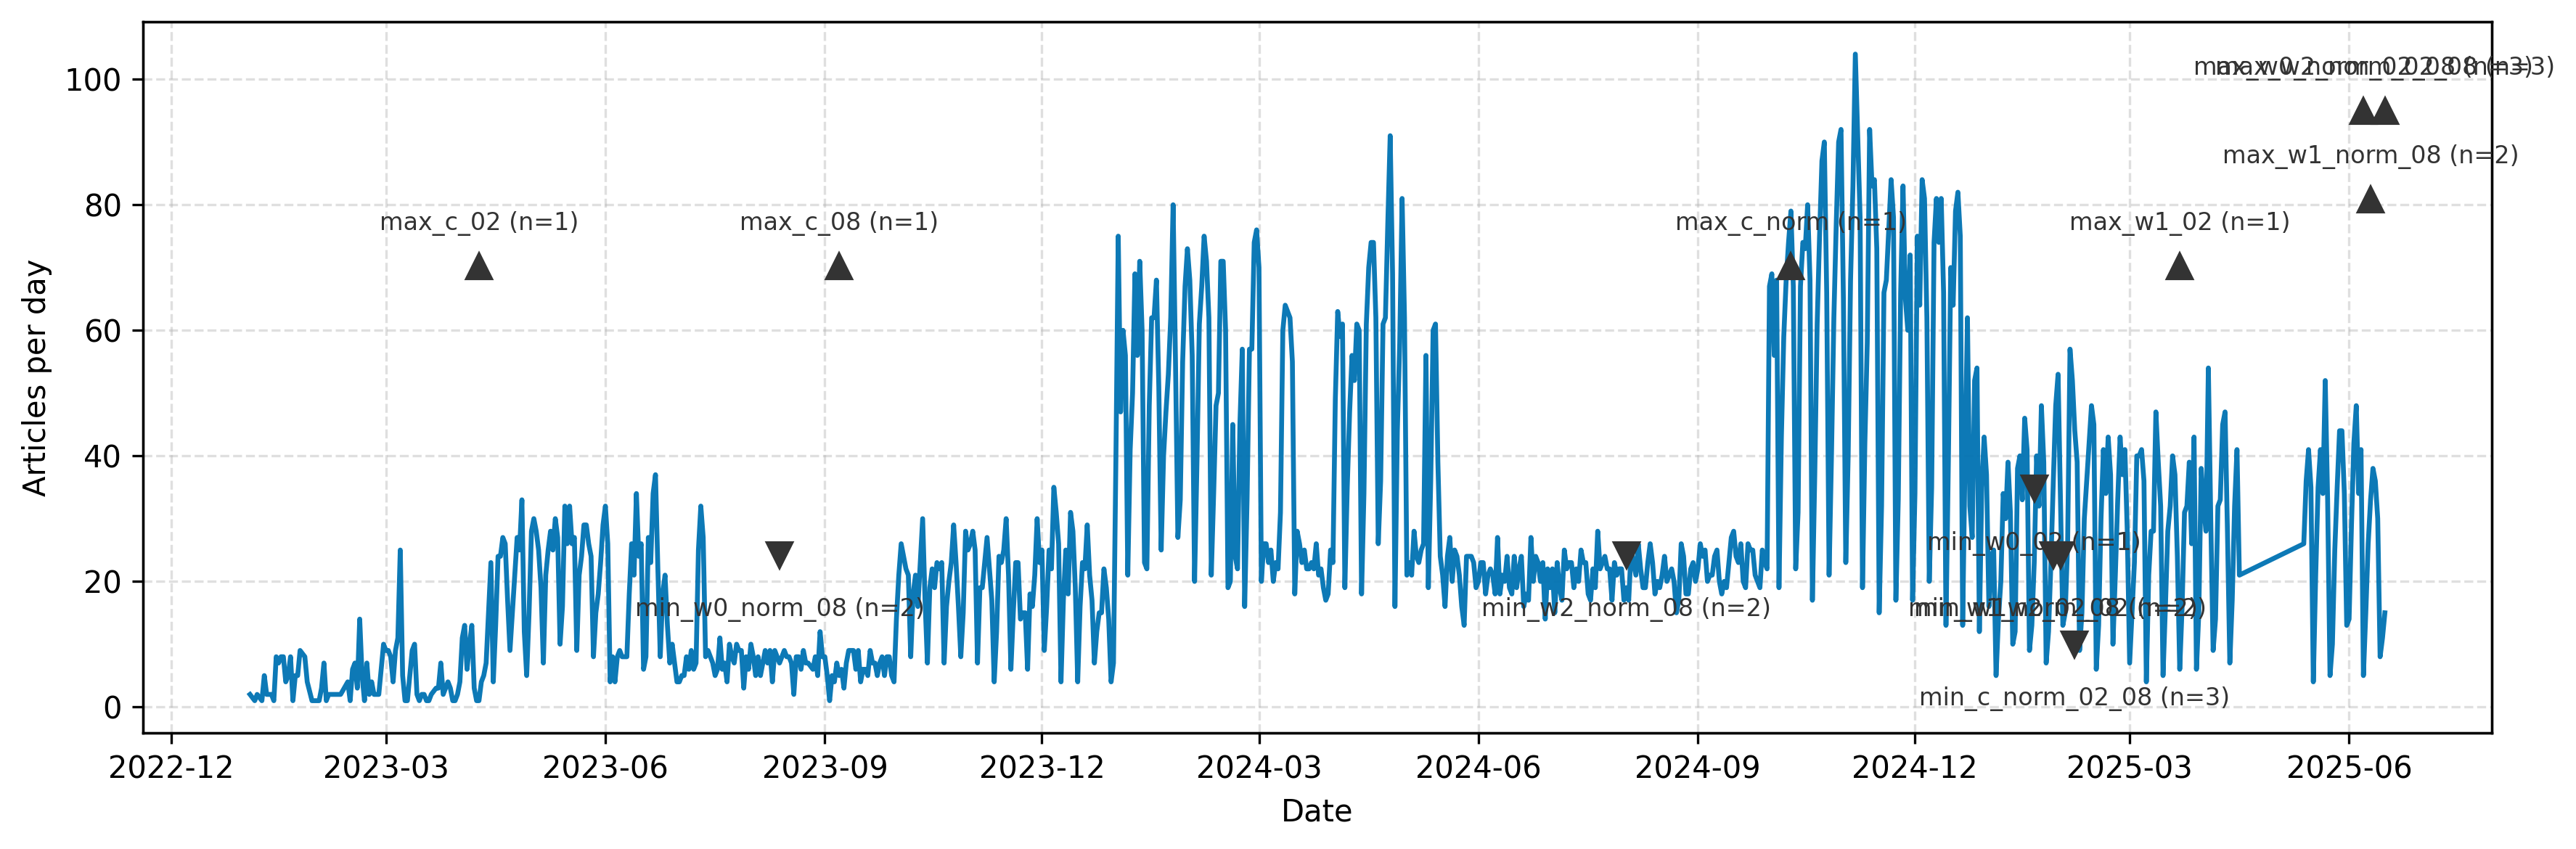

In [27]:
# plot timeline
fig, ax = plot_n_articles_with_extrema_events(
    dfp=dfp, date_col=None, count_col="n_articles",
    outpath="reports/figures/n_articles_with_extrema.png", annotate=True
)

In [28]:
# save extrema for reporting
extrema.sort_values(["type","n measures"],ascending=(False,False)).to_csv(var_path/ "extrema.csv")

Ensure article count does not bias AINI

Manually investiagte Minima & Maxima

In [29]:
# drop noisy estimates
#merged_clean = merged[merged["date"] != min_1]

# ensure datetime type
complete_df["date"] = pd.to_datetime(complete_df["date"], errors="coerce")

# subsets per year
df_2023 = complete_df[complete_df["date"].dt.year == 2023]
df_2024 = complete_df[complete_df["date"].dt.year == 2024]
df_2025 = complete_df[complete_df["date"].dt.year == 2025]



Investigate AINI by year

Compare measures across each other

In [30]:
# define columns for aggregation
w0_col = ["normalized_AINI_w0","EMA_02_w0","EMA_08_w0"]
w1_col = ["normalized_AINI_w1","EMA_02_w1","EMA_08_w1"]
w2_col = ["normalized_AINI_w2","EMA_02_w2","EMA_08_w2"]
c_col = ["normalized_AINI_custom","EMA_02_custom","EMA_08_custom"]

# calculate means
m["w0_mean"] = m[w0_col].mean(axis=1)
m["w1_mean"] = m[w1_col].mean(axis=1)
m["w2_mean"] = m[w2_col].mean(axis=1)
m["c_mean"]  = m[c_col].mean(axis=1)

# calc fractions
group_cols = ["w0_mean", "w1_mean", "w2_mean", "c_mean"]


yearly_means = (
    m.groupby(m["date"].dt.year)[group_cols]
     .mean()
)

# "total" over all years
total_means = m[group_cols].mean().to_frame().T
total_means.index = ["total"]

means = pd.concat([yearly_means, total_means])

# compute pairwise ratios
fractions = {}

for a in group_cols:
    for b in group_cols:
        if a != b:
            fractions[f"{a}/{b}"] = means[a] / means[b]

frac_df = pd.DataFrame(fractions)

print(frac_df.round(3))

       w0_mean/w1_mean  w0_mean/w2_mean  w0_mean/c_mean  w1_mean/w0_mean  \
2023             0.776            0.410           0.037            1.288   
2024            -0.095           -0.092          -0.005          -10.517   
2025            -2.559           -3.319          -0.028           -0.391   
total            0.058            0.045           0.003           17.381   

       w1_mean/w2_mean  w1_mean/c_mean  w2_mean/w0_mean  w2_mean/w1_mean  \
2023             0.528           0.047            2.438            1.892   
2024             0.968           0.058          -10.869            1.033   
2025             1.297           0.011           -0.301            0.771   
total            0.777           0.045           22.379            1.288   

       w2_mean/c_mean  c_mean/w0_mean  c_mean/w1_mean  c_mean/w2_mean  
2023            0.090          27.192          21.108          11.153  
2024            0.060        -182.559          17.358          16.797  
2025            0.008 

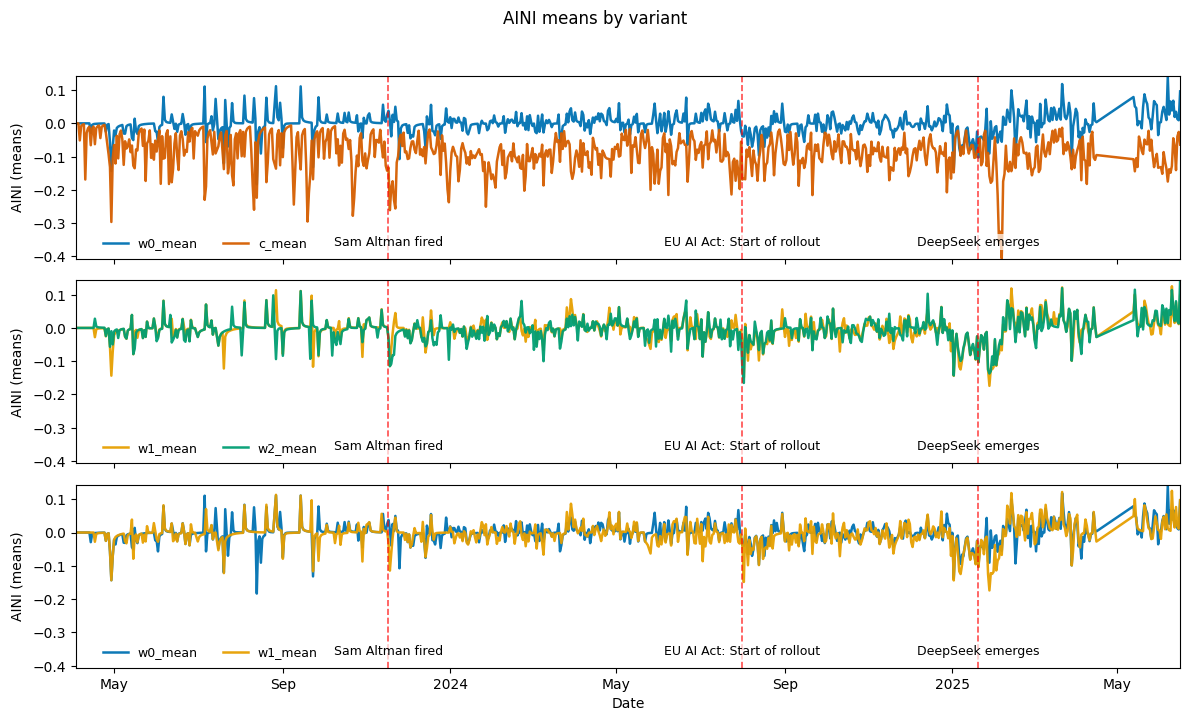

In [31]:
plot_path = fig_path / "aini_means.png"
plot_aini_means_three_panels(m,
                            title = "AINI means by variant",
                            outpath = plot_path )